# <center> Mobile Games A/B Testing - Cookie Cats Analysis <center>

## <center>Introduction</center>

### <center>Goal<center>

The primary goal of this A/B test is to evaluate the impact of moving the first gate in the Cookie Cats game from level 30 to level 40 on player retention and engagement. When players install the game, they are randomly assigned to either the control group (gate at level 30) or the test group (gate at level 40). By comparing player behavior between these two groups, we aim to identify the gate placement that results in better player retention and engagement.

### <center>Target Metric<center>

To measure the success of the gate placement change, we will focus on the following target metrics:
- `retention_1`: Indicates whether a player returned to play 1 day after installing the game.
- `retention_7`: Indicates whether a player returned to play 7 days after installing the game.
- `sum_gamerounds`: Represents the total number of game rounds played by a player within the first 14 days after installation.

By analyzing these metrics, we can assess how the gate placement influences player retention and engagement, and determine which gate placement yields the best performance.

### <center>Dataset Description<center>

The dataset contains the following columns:
- `userid`: A unique identifier for each player.
- `version`: Indicates whether the player was assigned to the control group (`gate_30`) or the test group (`gate_40`).
- `sum_gamerounds`: The total number of game rounds played by the player during the first 14 days after installation.
- `retention_1`: Whether the player returned to play 1 day after installing the game (1 if the player returned, 0 otherwise).
- `retention_7`: Whether the player returned to play 7 days after installing the game (1 if the player returned, 0 otherwise).

With this analysis, we will aggregate and prepare the data, conduct statistical tests to compare the two versions, estimate the treatment effects, and ultimately recommend the most effective gate placement strategy.

## <center> Imports and requirements <center>

In [1]:
%%capture
%pip install -r requirements.txt

The warnings library is used to hide unnecessary messages

In [2]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=DeprecationWarning)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utilities import helper_functions as hp
import scipy.stats as st
from scipy.stats import chi2_contingency, ttest_ind

## <center> Loading and cleaning dataset <center>

In [4]:
game_data= pd.read_csv('datasets/cookie_cats.csv')
game_data.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


Here we apply one of the helper functions to lowercase text and remove whitespaces. This is done so that the duplication check is more accurate.

In [5]:
game_data['version'] = game_data['version'].apply(hp.clean_string)

In [6]:
game_data.isnull().sum()

userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64

In [7]:
game_data.dtypes

userid             int64
version           object
sum_gamerounds     int64
retention_1         bool
retention_7         bool
dtype: object

In [8]:
game_data.duplicated().sum()

0

First lets check if there are any abnormalities with played rounds by each player.

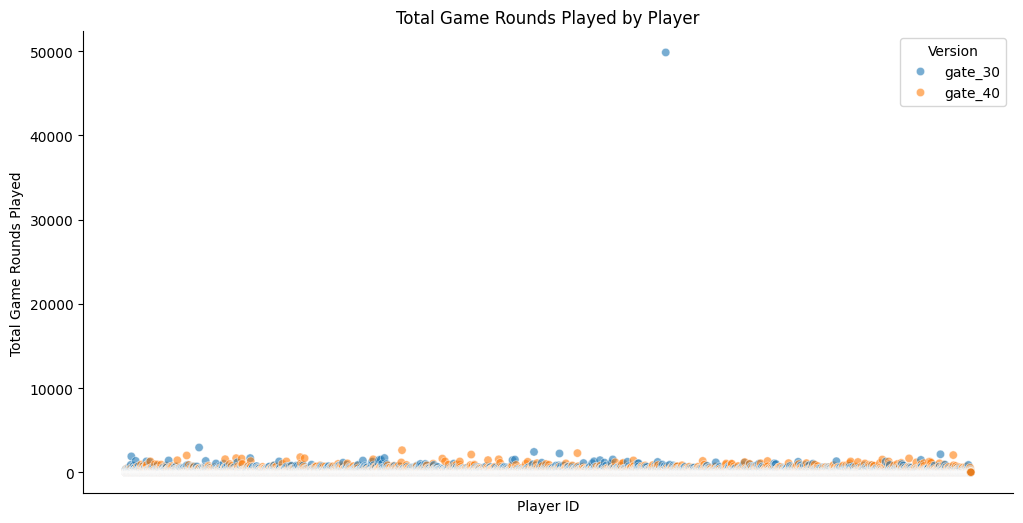

In [9]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='userid', y='sum_gamerounds', hue='version', data=game_data, alpha=0.6)
plt.title('Total Game Rounds Played by Player')
plt.xlabel('Player ID')
plt.xticks([])
plt.ylabel('Total Game Rounds Played')
plt.legend(title='Version')
sns.despine()
plt.show()

As we can see one player has massively more rounds played then other players. Lets remove him from out dataset.

In [10]:
max_rounds_player = game_data.loc[game_data['sum_gamerounds'].idxmax()]
game_data = game_data[game_data['userid'] != max_rounds_player['userid']]

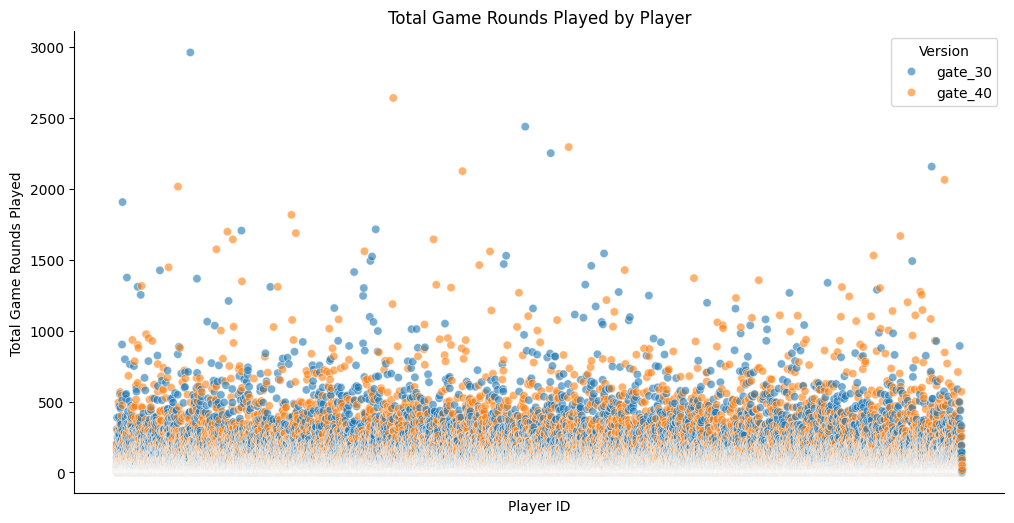

In [11]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='userid', y='sum_gamerounds', hue='version', data=game_data, alpha=0.6)
plt.title('Total Game Rounds Played by Player')
plt.xlabel('Player ID')
plt.xticks([])
plt.ylabel('Total Game Rounds Played')
plt.legend(title='Version')
sns.despine()
plt.show()

## <center>EDA<center>

In [12]:
game_data.shape

(90188, 5)

In [13]:
game_data['sum_gamerounds'].describe()

count    90188.000000
mean        51.320253
std        102.682719
min          0.000000
25%          5.000000
50%         16.000000
75%         51.000000
max       2961.000000
Name: sum_gamerounds, dtype: float64

Let's check the retention distributions from different aspects.

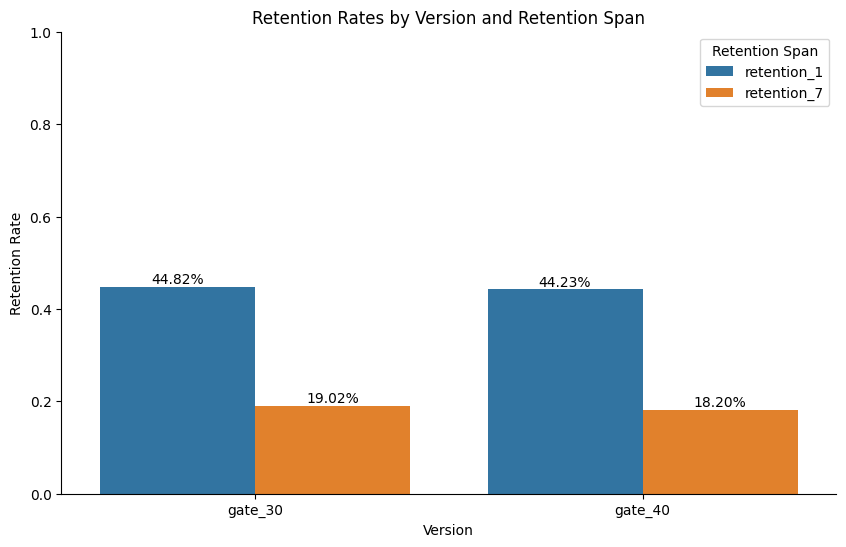

In [14]:
retention_rates = game_data.groupby('version')[['retention_1', 'retention_7']].mean().reset_index()
melted_retention = pd.melt(retention_rates, id_vars='version', value_vars=['retention_1', 'retention_7'],
                           var_name='Retention Span', value_name='Retention Rate')

plt.figure(figsize=(10, 6))
ax = sns.barplot(x='version', y='Retention Rate', hue='Retention Span', data=melted_retention)
plt.title('Retention Rates by Version and Retention Span')
plt.xlabel('Version')
plt.ylabel('Retention Rate')
plt.ylim(0, 1)
sns.despine()

for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(f'{height * 100:.2f}%', (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom')

plt.show()

As we can see, retention rates for both versions are pritty similar. Lets look if there is any correlation between retention and played rounds counts.

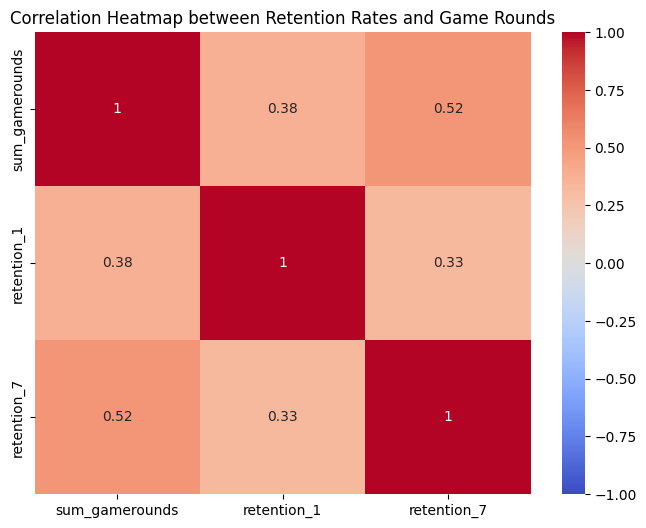

In [15]:
correlation_matrix = game_data[['sum_gamerounds', 'retention_1', 'retention_7']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap between Retention Rates and Game Rounds')
plt.show()

As expected, we can see a positive correlation between game rounds played and retention. It seems like the correlation between 7-day retention and game rounds is the strongest, but it is still not strong enough to make assumptions.

## <center> A\B testing <center>

Starting the A/B tests, I formulated hypotheses. After doing that, I decided that I needed three tests to make an informed decision about which game version is better. Here are the hypotheses for those tests:

### Retention after 1 Day (retention_1)
<br>
Null Hypothesis (H0)<br>
There is no difference in the 1-day retention rate between the players who encountered the gate at level 30 and those who encountered the gate at level 40.<br>
𝐻0:𝜇1=𝜇2<br>
​<br>
Alternative Hypothesis (H1)<br>
There is a difference in the 1-day retention rate between the players who encountered the gate at level 30 and those who encountered the gate at level 40.<br>
𝐻1:𝜇1!=𝜇2<br>
<br>
We will set alpha = 0.05<br>

### Retention after 7 Days (retention_7)
<br>
Null Hypothesis (H0)<br>
There is no difference in the 7-day retention rate between the players who encountered the gate at level 30 and those who encountered the gate at level 40.<br>
𝐻0:𝜇1=𝜇2<br>
​<br>
Alternative Hypothesis (H1)<br>
There is a difference in the 7-day retention rate between the players who encountered the gate at level 30 and those who encountered the gate at level 40.<br>
𝐻1:𝜇1!=𝜇2<br>
<br>
We will set alpha = 0.05<br>
<br>

### Total Game Rounds Played (sum_gamerounds)
<br>
Null Hypothesis (H0)<br>
There is no difference in the mean number of game rounds played between the players who encountered the gate at level 30 and those who encountered the gate at level 40.<br>
𝐻0:𝜇1=𝜇2<br>
​<br>
Alternative Hypothesis (H1)<br>
There is a difference in the mean number of game rounds played between the players who encountered the gate at level 30 and those who encountered the gate at level 40.<br>
𝐻1:𝜇1!=𝜇2<br>
<br>
We will set alpha = 0.05

In [16]:
game_data.groupby('version')['sum_gamerounds'].describe()

,count,mean,std,min,25%,50%,75%,max
version,,,,,,,,
gate_30,44699.0,51.342111,102.057598,0.0,5.0,17.0,50.0,2961.0
gate_40,45489.0,51.298776,103.294416,0.0,5.0,16.0,52.0,2640.0


In [17]:
sample_size = game_data['version'].value_counts()
sample_size

version
gate_40    45489
gate_30    44699
Name: count, dtype: int64

In [18]:
variant_proportion = game_data['version'].value_counts(normalize=True)
variant_proportion

version
gate_40    0.50438
gate_30    0.49562
Name: proportion, dtype: float64

Lets perform sanity test to check if samples are random.

In [19]:
contingency_table = pd.crosstab(index=game_data['version'], columns='count')

chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)

print("Chi-Square Test Statistic:", chi2_stat)
print("p-value:", p_val)
print("Degrees of Freedom:", dof)
print("Expected Frequencies:", expected)

Chi-Square Test Statistic: 0.0
p-value: 1.0
Degrees of Freedom: 0
Expected Frequencies: [[44699.]
 [45489.]]


As we get p-value of 1, and chi test statistic as 0.0 it suggests that sample is perfectly random.

### <center>Hypothesis 1: There is no difference in the 1-day retention rate between the players who encountered the gate at level 30 and those who encountered the gate at level 40.<center>

In [20]:
contingency_table_1 = pd.crosstab(game_data['version'], game_data['retention_1'])

chi2, p, dof, expected = chi2_contingency(contingency_table_1)

print(f"Chi-square test for retention_1: chi2 = {chi2}, p-value = {p}")

Chi-square test for retention_1: chi2 = 3.169835543170799, p-value = 0.07500999897705692


As we can see from p-value, its higher than our significance level of 0.05. Which means that we cant reject null hypothesis for now.

In [21]:
retention_rate_gate_30 = game_data[game_data['version'] == 'gate_30']['retention_1'].mean()
retention_rate_gate_40 = game_data[game_data['version'] == 'gate_40']['retention_1'].mean()

treatment_effect = retention_rate_gate_40 - retention_rate_gate_30

print(f"Retention rate for gate_30: {retention_rate_gate_30:.4f}")
print(f"Retention rate for gate_40: {retention_rate_gate_40:.4f}")
print(f"Treatment effect (gate_40 - gate_30): {treatment_effect:.4f}")

Retention rate for gate_30: 0.4482
Retention rate for gate_40: 0.4423
Treatment effect (gate_40 - gate_30): -0.0059


Judging by the treatment effect, we can see that the difference in retention rate is extremely small, which aligns with the previous information we obtained from the p-value.

In [22]:
n_gate_30 = game_data[game_data['version'] == 'gate_30'].shape[0]
n_gate_40 = game_data[game_data['version'] == 'gate_40'].shape[0]

se_gate_30 = np.sqrt(retention_rate_gate_30 * (1 - retention_rate_gate_30) / n_gate_30)
se_gate_40 = np.sqrt(retention_rate_gate_40 * (1 - retention_rate_gate_40) / n_gate_40)

z_score = st.norm.ppf(0.975)
ci_gate_30 = (retention_rate_gate_30 - z_score * se_gate_30, retention_rate_gate_30 + z_score * se_gate_30)
ci_gate_40 = (retention_rate_gate_40 - z_score * se_gate_40, retention_rate_gate_40 + z_score * se_gate_40)

In [23]:
retention_1_gate_30 = game_data[game_data['version'] == 'gate_30']['retention_1'].values
retention_1_gate_40 = game_data[game_data['version'] == 'gate_40']['retention_1'].values
bootstrap_ci_gate_30 = hp.bootstrap(retention_1_gate_30)
bootstrap_ci_gate_40 = hp.bootstrap(retention_1_gate_40)

In [24]:
print(f"Retention rate for gate_30: {retention_rate_gate_30:.4f}")
print(f"95% CI for gate_30: {ci_gate_30}")
print(f"Bootstrap 95% CI for gate_30: {bootstrap_ci_gate_30}")
print(f"Retention rate for gate_40: {retention_rate_gate_40:.4f}")
print(f"95% CI for gate_40: {ci_gate_40}")
print(f"Bootstrap 95% CI for gate_40: {bootstrap_ci_gate_40}")

Retention rate for gate_30: 0.4482
95% CI for gate_30: (0.44358768248139613, 0.4528082100441637)
Bootstrap 95% CI for gate_30: (0.44356697017830377, 0.4529855254032529)
Retention rate for gate_40: 0.4423
95% CI for gate_40: (0.4377186834721228, 0.44684681587936875)
Bootstrap 95% CI for gate_40: (0.43760029897337815, 0.44687726703159003)


#### <center> First hypothesis conclusion<center>
Based on the chi-square test results and the confidence intervals, we conclude that there is no significant difference in the 1-day retention rates between the players who encountered the gate at level 30 and those who encountered the gate at level 40. The small treatment effect of -0.0059 and the overlapping confidence intervals indicate that moving the gate from level 30 to level 40 does not have a substantial impact on the 1-day retention rate. For this reason we accept null hypothesis.

### <center>Hypothesis 2: There is no difference in the 7-day retention rate between the players who encountered the gate at level 30 and those who encountered the gate at level 40.<center>

In [25]:
contingency_table_2 = pd.crosstab(game_data['version'], game_data['retention_7'])

chi2, p, dof, expected = chi2_contingency(contingency_table_2)

print(f"Chi-square test for retention_7: chi2 = {chi2}, p-value = {p}")

Chi-square test for retention_7: chi2 = 9.91527552890567, p-value = 0.0016391259678654425


As we can see p-value is lower than 0.05 which indicates that there is significant differance for 7 day retention based on version.

In [26]:
week_retention_rate_gate_30 = game_data[game_data['version'] == 'gate_30']['retention_7'].mean()
week_retention_rate_gate_40 = game_data[game_data['version'] == 'gate_40']['retention_7'].mean()

week_treatment_effect = week_retention_rate_gate_40 - week_retention_rate_gate_30

print(f"Retention rate for gate_30: {week_retention_rate_gate_30:.4f}")
print(f"Retention rate for gate_40: {week_retention_rate_gate_40:.4f}")
print(f"Treatment effect (gate_40 - gate_30): {week_treatment_effect:.4f}")

Retention rate for gate_30: 0.1902
Retention rate for gate_40: 0.1820
Treatment effect (gate_40 - gate_30): -0.0082


The treatment effect of -0.0082 indicates that the 7-day retention rate for gate_40 is lower than for gate_30 by approximately 0.82%. This difference, though small, is statistically significant based on the chi-square test result.

In [27]:
week_se_gate_30 = np.sqrt(week_retention_rate_gate_30 * (1 - week_retention_rate_gate_30) / n_gate_30)
week_se_gate_40 = np.sqrt(week_retention_rate_gate_40 * (1 - week_retention_rate_gate_40) / n_gate_40)

z_score = st.norm.ppf(0.975)
week_ci_gate_30 = (week_retention_rate_gate_30 - z_score * week_se_gate_30, week_retention_rate_gate_30 + z_score * week_se_gate_30)
week_ci_gate_40 = (week_retention_rate_gate_40 - z_score * week_se_gate_40, week_retention_rate_gate_40 + z_score * week_se_gate_40)

In [28]:
retention_7_gate_30 = game_data[game_data['version'] == 'gate_30']['retention_7'].values
retention_7_gate_40 = game_data[game_data['version'] == 'gate_40']['retention_7'].values
week_bootstrap_ci_gate_30 = hp.bootstrap(retention_7_gate_30)
week_bootstrap_ci_gate_40 = hp.bootstrap(retention_7_gate_40)

In [29]:
print(f"Retention rate for gate_30: {week_retention_rate_gate_30:.4f}")
print(f"95% CI for gate_30: {week_ci_gate_30}")
print(f"Bootstrap 95% CI for gate_30: {week_bootstrap_ci_gate_30}")
print(f"Retention rate for gate_40: {week_retention_rate_gate_40:.4f}")
print(f"95% CI for gate_40: {week_ci_gate_40}")
print(f"Bootstrap 95% CI for gate_40: {week_bootstrap_ci_gate_40}")

Retention rate for gate_30: 0.1902
95% CI for gate_30: (0.18654509170051722, 0.19382135945051523)
Bootstrap 95% CI for gate_30: (0.18658135528759032, 0.19380746772858454)
Retention rate for gate_40: 0.1820
95% CI for gate_40: (0.17845430073314686, 0.18554578720019968)
Bootstrap 95% CI for gate_40: (0.17852667677900153, 0.18556134450086834)


Both the analytical and bootstrap confidence intervals for the retention rates of gate_30 and gate_40 show no overlap. This non-overlapping confidence interval further supports the conclusion of a significant difference between the two groups.

#### <center> Second hypothesis conclusion<center>
Based on the chi-square test results and the confidence intervals, we conclude that there is a significant difference in the 7-day retention rates between the players who encountered the gate at level 30 and those who encountered the gate at level 40. The treatment effect of -0.0082 and the non-overlapping confidence intervals indicate that moving the gate from level 30 to level 40 results in a lower 7-day retention rate. For this reason we reject null hypothesis.

### <center>Hypothesis 3: There is no difference in the mean number of game rounds played between the players who encountered the gate at level 30 and those who encountered the gate at level 40.<center>

In [30]:
mean_rounds_gate_30 = game_data[game_data['version'] == 'gate_30']['sum_gamerounds'].mean()
mean_rounds_gate_40 = game_data[game_data['version'] == 'gate_40']['sum_gamerounds'].mean()
print(f"Mean game rounds for gate_30: {mean_rounds_gate_30:.2f}")
print(f"Mean game rounds for gate_40: {mean_rounds_gate_40:.2f}")

Mean game rounds for gate_30: 51.34
Mean game rounds for gate_40: 51.30


In [31]:
game_rounds_gate_30 = game_data[game_data['version'] == 'gate_30']['sum_gamerounds']
game_rounds_gate_40 = game_data[game_data['version'] == 'gate_40']['sum_gamerounds']

t_stat, p_val = ttest_ind(game_rounds_gate_30, game_rounds_gate_40, equal_var=False)
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_val:.4f}")

T-statistic: 0.0634
P-value: 0.9495


Since the p-value (0.9495) is significantly greater than the common significance level of 0.05, we fail to reject the null hypothesis. This suggests that there is no significant difference in the mean number of game rounds played between the players who encountered the gate at level 30 and those who encountered the gate at level 40.

In [32]:
round_se_gate_30 = np.std(game_rounds_gate_30, ddof=1) / np.sqrt(n_gate_30)
round_se_gate_40 = np.std(game_rounds_gate_40, ddof=1) / np.sqrt(n_gate_40)

rounds_ci_gate_30 = st.t.interval(0.95, n_gate_30-1, loc=mean_rounds_gate_30, scale=round_se_gate_30)
rounds_ci_gate_40 = st.t.interval(0.95, n_gate_40-1, loc=mean_rounds_gate_40, scale=round_se_gate_40)

In [33]:
bootstrap_round_ci_gate_30 = hp.bootstrap(game_rounds_gate_30)
bootstrap_round_ci_gate_40 = hp.bootstrap(game_rounds_gate_40)

In [34]:
print(f"Bootstrap 95% CI for gate_30: {bootstrap_round_ci_gate_30}")
print(f"95% CI for gate_30: {rounds_ci_gate_30}")
print(f"Bootstrap 95% CI for gate_40: {bootstrap_round_ci_gate_40}")
print(f"95% CI for gate_40: {rounds_ci_gate_40}")

Bootstrap 95% CI for gate_30: (50.39539698874695, 52.2884085773731)
95% CI for gate_30: (50.39596863079293, 52.288252492722144)
Bootstrap 95% CI for gate_40: (50.34187495878125, 52.242140957154476)
95% CI for gate_40: (50.34951964432881, 52.248031411970516)


#### <center> Third hypothesis conclusion<center>
Based on the independent t-test results and the confidence intervals, we conclude that there is no significant difference in the mean number of game rounds played between the players who encountered the gate at level 30 and those who encountered the gate at level 40. The very small difference in means (51.34 for gate_30 and 51.30 for gate_40) and the high p-value indicate that moving the gate from level 30 to level 40 does not have a substantial impact on the total number of game rounds played.

## <center>Conclusion<center>

Based on these findings, it is recommended to keep the gate at level 30 to avoid negatively impacting the 7-day retention rate. While the position of the gate does not significantly affect 1-day retention or total game rounds played, the reduction in 7-day retention when the gate is moved to level 40 suggests that the original placement at level 30 is more beneficial for long-term player engagement.